In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Birthday paradox

**Problem 1a.** During exercise session, we showed that for $d$ equally likely dates in a year and $n$ people, the probability of a repeat date is $p(n)=1-\frac{d^\underline{n}}{d^n}$. We also derived a simple approximate formula for this probability: $p_a(n) = 1-e^{-\frac{n(n-1)}{2d}}$. In particular, this approximation implies that for $d=365$ dates, $p(n)$ is close to $\frac{1}{2}$ for $n=23$.

Verify how good the approximation is. To this end, write a program that computes the exact value of $p(n)$ as well as the value of the approximation $p_a(n)$ for $d=365$ and $n=1,\ldots,60$. Plot the graphs of the two functions.

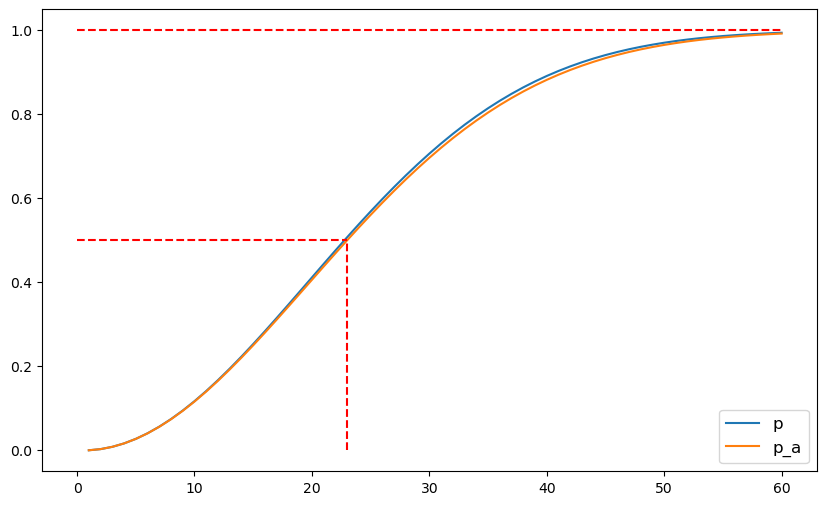

In [24]:
# pure Python implementation
def p(d, n):
    v = 1.0
    for i in range(n):
        v = v * (d - i) / d
    return 1 - v


# numpy implementation
def p_numpy(d, n):
    d_fact = np.arange(d, d - n, step=-1, dtype=np.float32)
    d = np.repeat(d, n)
    return 1. - np.prod(d_fact / d)
    

def p_a(d, n):
    return 1 - np.exp(-0.5 * n * (n - 1) / d)


d = 365
n = 60
x = range(1, n + 1)

# list comprehensions
y = [p(d, i) for i in x]
y_numpy = [p_numpy(d, i) for i in x]
y_a = [p_a(d, i) for i in x]

# check if numpy version and Python give the same results
assert np.isclose(y, y_numpy).all()

# create plot
plt.figure(figsize=(10,6))
x_plot, = plt.plot(x, y_numpy, label="p")
x_a_plot, = plt.plot(x, y_a, label="p_a")
plt.hlines([0.5,1.0], [0,0], [23,60], colors='red', linestyles='dashed')
plt.vlines([23], [0], [0.5], colors='red', linestyles='dashed')

plt.legend(handles=[x_plot, x_a_plot], loc=4, fontsize='large')
plt.show()

# we can see that the approximation is relatively good

**Problem 1b.**
Implement a function, that chooses random dates out of $1,\ldots,d$ until a repeat occurs. The function should return the number of the step in which that happened. Run the function $N=100\,000$ times.
    * Plot a histogram of the return values.
    * Which return value seems most likely? 
    * What is the average of the return values?
    * Is there any simple relation between these two numbers and the value $23$ in the previous problem?
    * Is there any simple relation between the histogram obtained, and the plot in the previous problem?

In [26]:
import random


def dates(d):
    s = set()
    for k in range(d + 1):
        x = random.randint(1, d)  # alternative: np.random.randint(1, d + 1)
        if x in s:
            return k + 1
        else:
            s.add(x)


d = 365
sample = [dates(d) for iter in range(100000)]

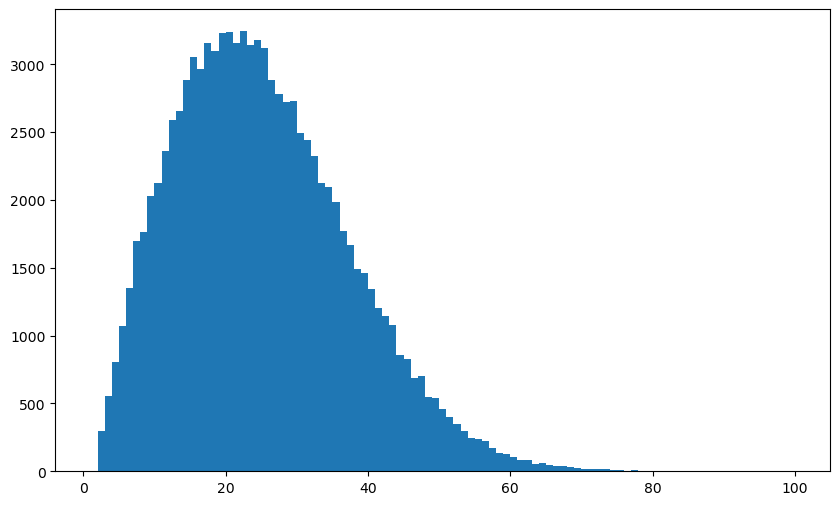

Couple first most likely values: [22, 20, 19, 24, 21, 17, 23, 25, 18, 15]
Average value: 24.64089
Average value using numpy: 24.64089


In [9]:
plt.figure(figsize=(10, 6))
plt.hist(sample, bins=range(1, 101))
plt.show()

# calcultating most probable values in pure Python
k_counts = sorted(list(set(sample)), key=sample.count, reverse=True)

# numpy version
vals, counts = np.unique(sample, return_counts=True)
k_counts_numpy = vals[np.argsort(counts)][::-1]

# check numpy results
# for all values there may be problems with ties so check only first 10 (still might fail rarely)
assert (k_counts_numpy[:10] == k_counts[:10]).all()

print('Couple first most likely values: {}'.format(k_counts[:10]))

print('Average value: {}'.format(float(sum(sample)) / len(sample)))
print('Average value using numpy: {}'.format(np.mean(sample)))

**Problem 1c.** Here we investigate how our analysis using the classical approach compares to a more empirical one. The file *us_births_69_88.csv* contains the counts for birthdates from 1969 to 1988. Only those births, for which the full date is known, are included in the file.
    * Read the file.
    * Investigate the data. Do you notice anything strange?
    * Plot a heatmap of the data. Do you notice any significant deviations from the uniform assumption? Can you explain them?
    * Implement a sampling function as in 1b, but this time using the supplied data. Compare the results.

In [28]:
# use pandas to read data
stats = pd.read_csv('us_births_69_88.csv')
stats.head()

,month,day,births
0,1,1,160369
1,1,2,169896
2,1,3,180036
3,1,4,182854
4,1,5,184145


In [29]:
# data contains several errors
# 98 people born on february 30th ...
stats.set_index(['month', 'day']).loc[(2, 30)]

births    98
Name: (2, 30), dtype: int64

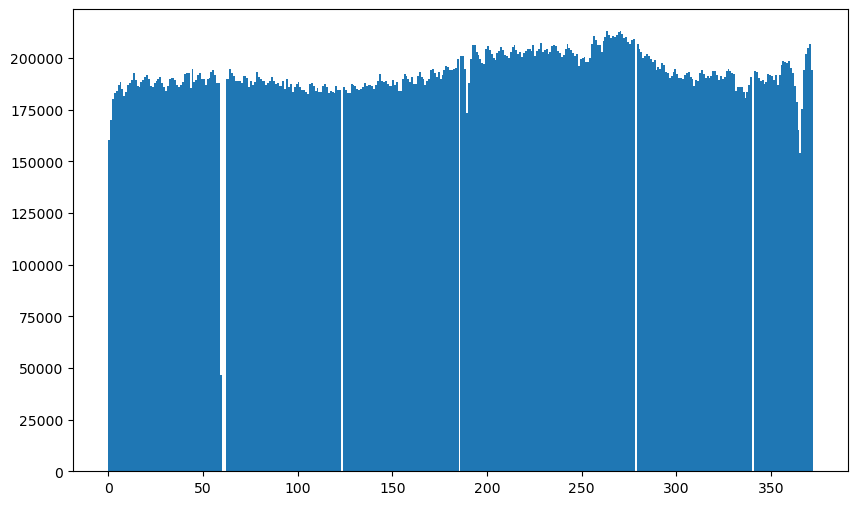

In [12]:
# convert to numpy.ndarray
stats = stats.values

plt.figure(figsize=(10, 6))
plt.hist(np.arange(stats.shape[0]), 
         weights=stats[:, 2], 
         bins=np.arange(stats.shape[0] + 1))
plt.show()

# Generally we see more births during june-august

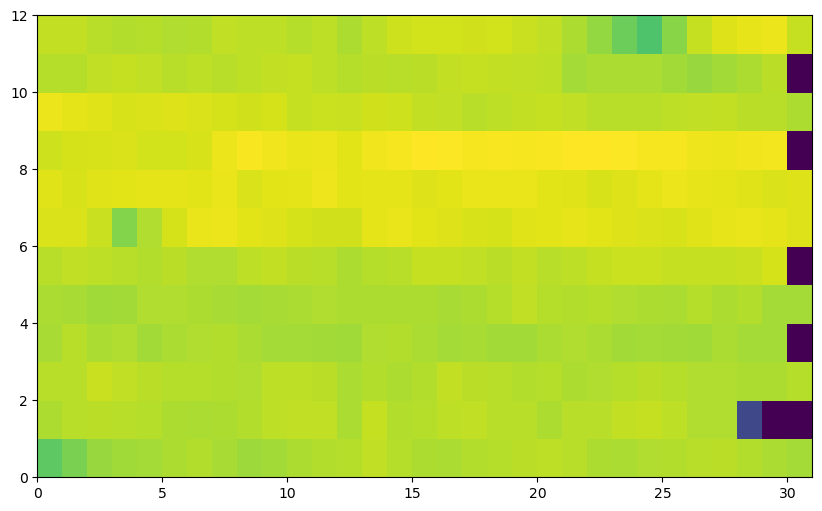

In [17]:
counts = np.zeros((12, 31), dtype=np.int32)

# use advanced indexing with a tuple of array indices
counts[stats[:, 0] - 1, stats[:, 1] - 1] = stats[:, 2]
    
plt.figure(figsize=(10, 6))
plt.pcolor(counts)
plt.show()

# plot birth counts again but with heatmap

In [19]:
# pref_sums contains prefix sums of birth counts
def emp_dates(pref_sums):
    s = set()
    for k in np.arange(len(pref_sums) + 1):
        # sample x uniformly between [1, total_births]
        x = np.random.randint(1, pref_sums[-1] + 1)
        # sample day with probability proportional to birth count using binary search
        day = np.searchsorted(pref_sums, x, side='left')
        if day in s:
            return k + 1
        else:
            s.add(day)


pref_sums = np.cumsum(stats[:, 2])
emp_sample = [emp_dates(pref_sums) for iter in range(100000)]

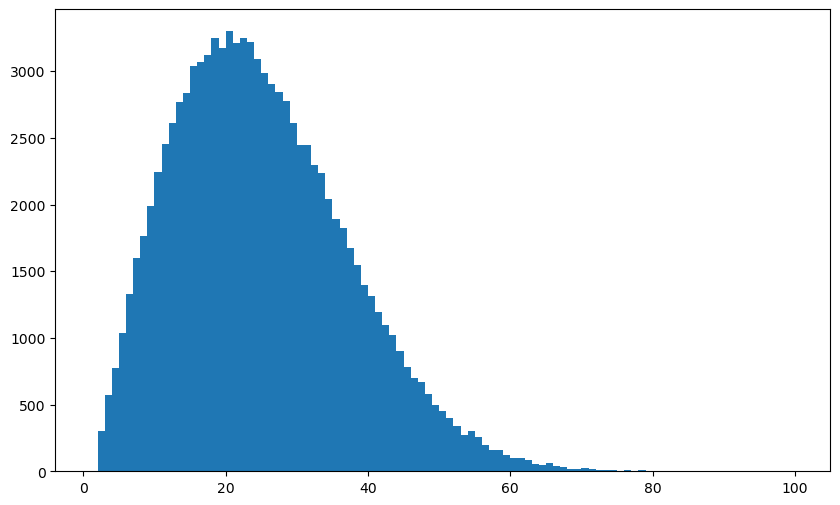

Couple first most likely values: [20, 18, 22, 23, 21, 19, 17, 24, 16, 15]
Average value: 24.58094
Average value using numpy: 24.58094


In [21]:
plt.figure(figsize=(10, 6))
plt.hist(emp_sample, bins=range(1, 101))
plt.show()

# calcultating most probable values in pure Python
k_counts = sorted(list(set(emp_sample)), key=emp_sample.count, reverse=True)

# numpy version
vals, counts = np.unique(emp_sample, return_counts=True)
k_counts_numpy = vals[np.argsort(counts)][::-1]

# check numpy results
# for all values there may be problems with ties so check only first 10 (still might fail rarely)
assert (k_counts_numpy[:10] == k_counts[:10]).all()

print('Couple first most likely values: {}'.format(k_counts[:10]))

print('Average value: {}'.format(float(sum(emp_sample)) / len(emp_sample)))
print('Average value using numpy: {}'.format(np.mean(emp_sample)))

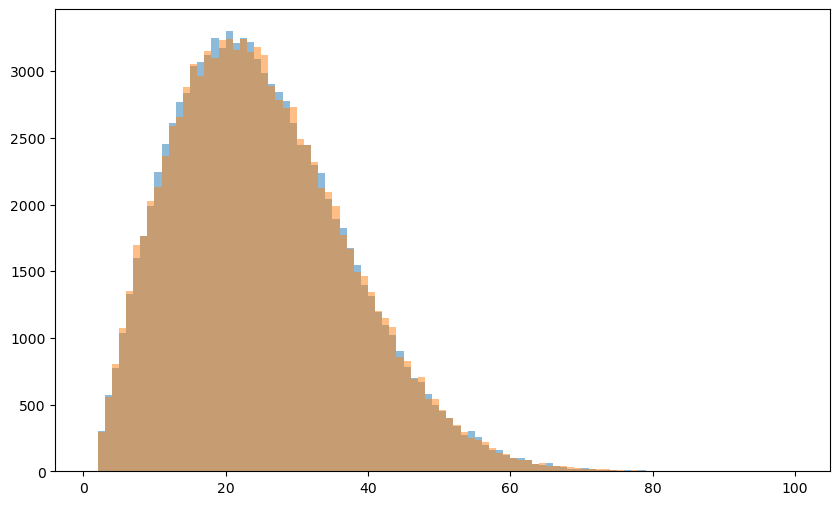

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(emp_sample, bins=range(1, 101), alpha=0.5)
plt.hist(sample, bins=range(1, 101), alpha=0.5)
plt.show()

# compare both histograms